<a href="https://colab.research.google.com/github/kvbd176/Spam_emails_detecting/blob/main/Detecting_spam_emails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

#libraries required for modelflow and building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('emails.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
data.shape

(5171, 4)

<function matplotlib.pyplot.show(close=None, block=None)>

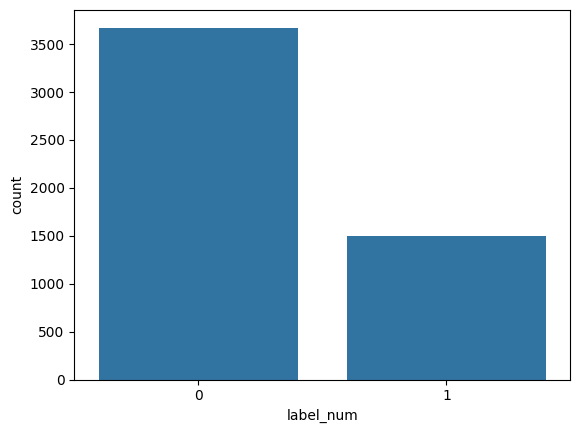

In [ ]:
sns.countplot(x='label_num',data=data)
plt.show

Text(0.5, 0, 'Message Types')

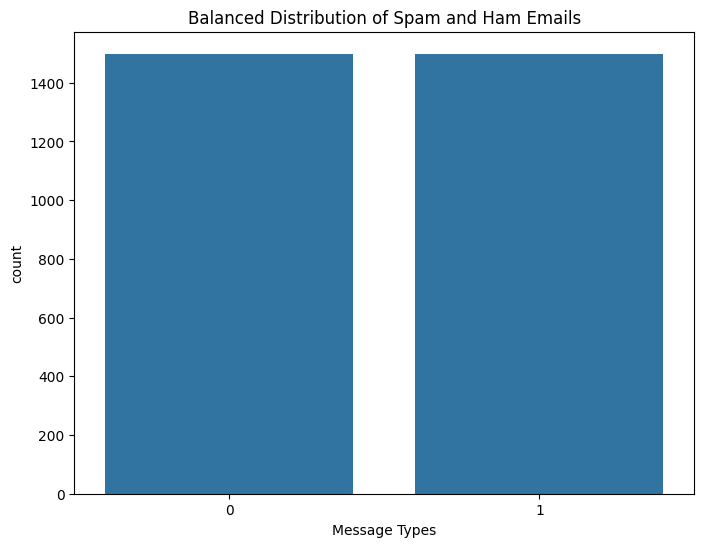

In [ ]:
ham_msg=data[data['label_num']==0]
spam_msg=data[data['label_num']==1]

# Downsample Ham emails to match the number of Spam emails
hambalanced=ham_msg.sample(n=len(spam_msg),random_state=42)

# Combine balanced data
balanced_data = pd.concat([hambalanced,spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
plt.figure(figsize=(8,6))
sns.countplot(x='label_num', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
#plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.xlabel('Message Types')
#plt.show()

## Text Preprocessing

In [ ]:
balanced_data['text']=balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [ ]:
#removes all the punctuations inside the text
punctuations_list=string.punctuation
def remove_punctuations(text):
    temp=str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [ ]:
def remove_stopwords(text):
    stop_words=stopwords.words('english')
    imp_words=[]
    # Storing the important words
    for word in str(text).split():
        word=word.lower()
        if word not in stop_words:
            imp_words.append(word)

    output=" ".join(imp_words)
    return output

balanced_data['text']=balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


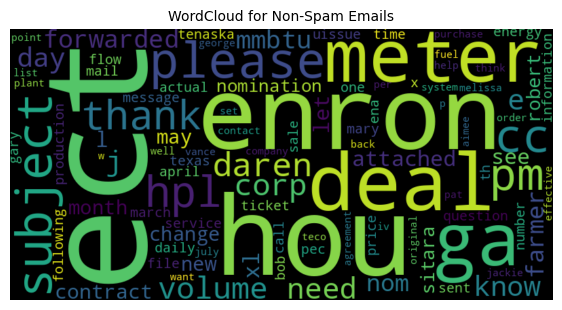

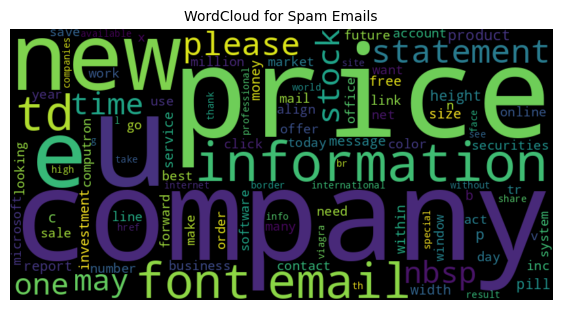

In [ ]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=10)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label_num']==0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num']==1], typ='Spam')

## Text Data to Numerical Vectors

In [ ]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'],
    balanced_data['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_data['label_num']
)

In [ ]:
#tokenize the data
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_X)

#convert text to sequences
train_sequences=tokenizer.texts_to_sequences(train_X)
test_sequences=tokenizer.texts_to_sequences(test_X)

#padding sequences to have same lemgth
max_len=100
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

## Developing Model

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(max_len,)))
model.add(tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=32
    ))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 32)        │     1,236,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,777 (4.73 MB)

 Trainable params: 1,239,777 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

## Callback

In [ ]:
es=EarlyStopping(patience=3,
                 monitor='val_accuracy',
                 restore_best_weights=True)
lr=ReduceLROnPlateau(patience=2,
                     monitor='val_loss',
                     factor=0.5,
                     verbose=0)

In [ ]:
history=model.fit(
    train_sequences,train_Y,
    validation_data=(test_sequences,test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr,es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.5163 - loss: 0.6928 - val_accuracy: 0.5983 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7795 - loss: 0.5281 - val_accuracy: 0.9517 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9743 - loss: 0.1459 - val_accuracy: 0.9683 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9804 - loss: 0.1166 - val_accuracy: 0.9667 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9850 - loss: 0.0892 - val_accuracy: 0.9583 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9883 - loss: 0.0708 - val_accuracy: 0.9633 - val_loss: 0.1667 - learning_rate: 5.0000e-04


In [ ]:
test_loss,test_accuracy=model.evaluate(test_sequences,test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9661 - loss: 0.1464
Test Loss : 0.14113982021808624
Test Accuracy : 0.9683333039283752


## Model Evaluation

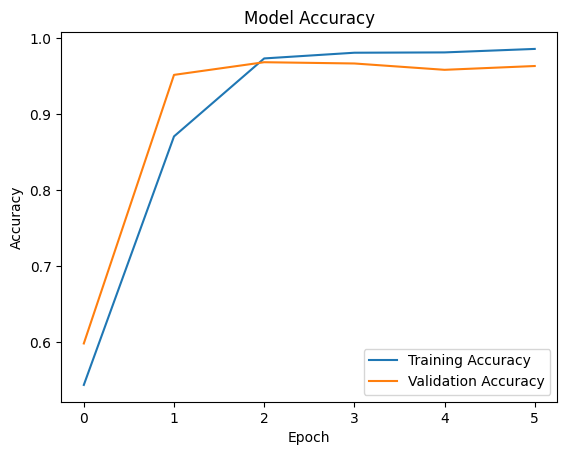

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()